# Evaluate the monthly means of modeled Bering Strait Transports
This notebook compares the monthly means for the freshwater flux, heat flux, and volume transport through Bering Strait using the Woodgate moored observational product (1991-2019) and the following CM4 simulations:
1. CMIP6-CM4
2. Odiv-200
3. Odiv-209

Transports and fluxes are calculated using the definitions from from Woodgate et al. 2018. Model transport, $T_{vol}$, is the meridonal mass transport, $vmo$, divided by the reference density, $\rho_0$. 

The freshwater flux, $T_{FW}$ is calculated as follows:
$$T_{FW} = T_{vol} \left( 1 - \frac{S}{S_{ref}} \right)$$ where $S_{ref} = 34.8$ psu.

Heat fluxes, $T_{Heat}$, are calculated as follows:
$$T_{Heat} = \rho T_{vol} c_w \left( \theta - \theta_{ref} \right)$$ where $\theta_{ref} = -1.9^\circ C$, $\rho = 1023$ kg m$^{-3}$ ; and $c_w = 3900$ J(kg K)$^{-1}$.

Transports and fluxes are calculated at each grid point and then intergrated across Bering Strait's cross-sectional area.

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
from glob import glob
import xarray as xr
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
import numpy as np

## Set up DASK cluster
In dask labextension, create a +NEW cluster. Click the < > widget, scale it to 16 workers and let's go!

## Set parameters

In [3]:
# Model reference density [kg/m3]
rho_0 = 1035
# Cross-sectional area of strait [m^2]
area_BS = 4.25e6

## Set paths

In [4]:
## CMIP6 CM4
# base
base_cmip6 = '/archive/oar.gfdl.cmip6/CM4/warsaw_201710_om4_v1.0.1/'
# pi
cmip6_PI = base_cmip6 + 'CM4_piControl_C/gfdl.ncrc4-intel16-prod-openmp/pp/ocean_Bering_Strait/'
# CM4 historical
cmip6_HI = base_cmip6 + 'CM4_historical/gfdl.ncrc4-intel16-prod-openmp/pp/ocean_Bering_Strait/'

In [5]:
# base for high res experiments
base_hres = '/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/'
## ODiv 191
# 0.8 degree MOM6 ocean with c192 atmosphere with remap scheme = P1M_H2 and MLE decay time at 10 days
odiv191_PI = base_hres + 'CM4_piControl_c192_OM4p125_v6/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Bering_Strait/'
## ODiv 200
# 0.8 degree MOM6 ocean with c192 atmosphere with remap scheme = P1M_H2 and MLE decay time at 20 days
odiv200_PI = base_hres + 'CM4_piControl_c192_OM4p125_v6_alt1/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Bering_Strait/'
## ODiv 206
# 0.8 degree MOM6 ocean with c192 atmosphere with remap scheme = P1M_H2 and MLE decay time at 20 days and 
# ice-albedo +1.0 tuning but starts at year 180
odiv206_PI = base_hres + 'CM4_piControl_c192_OM4p125_v6_alt2/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Bering_Strait/'
## ODiv 207
# 0.8 degree MOM6 ocean with c192 atmosphere with remap scheme = P1M_H2 and MLE decay time at 20 days and 
# ice-albedo +1.0 tuning and land ice tuning F_iso = 0.8 but starts at year 180
odiv207_PI = base_hres + 'CM4_piControl_c192_OM4p125_v6_alt3/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Bering_Strait/'
## ODiv 209
# 0.8 degree MOM6 ocean with c192 atmosphere with remap scheme = P1M_H2 and MLE decay time at 20 days and 
# ice-albedo +1.0 tuning and land ice tuning F_iso = 0.8
odiv209_PI = base_hres + 'CM4_piControl_c192_OM4p125_v7/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Bering_Strait/'
## ODiv 210
# 1/4 degree MOM6 ocean with c192 atmosphere with remap scheme = P1M_H2 and MLE decay time at 20 days and 
# ice-albedo +1.0 tuning and land ice tuning F_iso = 0.8
odiv210_PI = base_hres + 'CM4_piControl_c192_OM4p25_v7/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_Bering_Strait/'

In [6]:
## OM4 with JRA forcing
# base
base_om4 = '/archive/Raphael.Dussin/xanadu_esm4_20190304_mom6_2019.08.08/'
# historical
om4_HI = base_om4 + 'OM4p25_JRA55do1.4_0netfw_cycle6/gfdl.ncrc4-intel16-prod/pp/ocean_Bering_Strait/'

In [7]:
# output directories
cmip6_PI_dir = cmip6_PI + 'ts/daily/5yr/'
cmip6_HI_dir = cmip6_HI + 'ts/daily/5yr/'
odiv209_PI_dir = odiv209_PI + 'ts/daily/10yr/'
odiv210_PI_dir = odiv210_PI + 'ts/daily/10yr/'
om4_HI_dir = om4_HI + 'ts/daily/20yr/'

## Get model file lists

In [8]:
## CMIP6 CM4
# pi
filelistCMIP6pi = glob(f'{cmip6_PI_dir}*.nc')
# historical
filelistCMIP6hi = glob(f'{cmip6_HI_dir}*.nc')

In [9]:
## ODIV209 CM4
# pi
filelistODIV209 = glob(f'{odiv209_PI_dir}*.nc')
# historical

In [10]:
## ODIV210 CM4
# pi
filelistODIV210 = glob(f'{odiv210_PI_dir}*.nc')
# historical

In [11]:
## OM4 with JRA forcing
# historical
filelistOM4 = glob(f'{om4_HI_dir}*.nc')

## Read in model data

In [12]:
def open_model_data(flist):
    import xarray as xr
    
    # open and clean up model data
    DS = xr.open_mfdataset(flist,use_cftime=True,combine='by_coords',engine='netcdf4',
                           drop_variables=['average_DT', 'average_T1', 'average_T2']
                          ).rename_dims({'yh_sub01':'yh','xh_sub01':'xh','yq_sub01':'yq'}
                                       ).rename({'yh_sub01':'yh','xh_sub01':'xh','yq_sub01':'yq'}
                                               ).squeeze()
    
    return DS

In [13]:
# CMIP6 CM4 pi
DS_cmip6pi = open_model_data(filelistCMIP6pi).chunk({'time':10000})

In [14]:
# CMIP6 CM4 historical
DS_cmip6hi = open_model_data(filelistCMIP6hi).chunk({'time':10000})

In [15]:
# ODIV209 CM4
DS_o209 = open_model_data(filelistODIV209).chunk({'time':30000})
# Fix weirdness with vmo coord
DS_o209['vmo'] = DS_o209.vmo.assign_coords(xh=("xh_sub02", DS_o209.xh)).swap_dims({"xh_sub02": "xh"})
DS_o209['vo'] = DS_o209.vo.assign_coords(xh=("xh_sub02", DS_o209.xh)).swap_dims({"xh_sub02": "xh"})

In [16]:
# ODIV210 CM4
DS_o210 = open_model_data(filelistODIV210).chunk({'time':10000})
# Fix weirdness with vmo coord
DS_o210['vmo'] = DS_o210.vmo.assign_coords(xh=("xh_sub02", DS_o210.xh)).swap_dims({"xh_sub02": "xh"})
DS_o210['vo'] = DS_o210.vo.assign_coords(xh=("xh_sub02", DS_o210.xh)).swap_dims({"xh_sub02": "xh"})

In [17]:
# OM4 with JRA
DS_om4 = open_model_data(filelistOM4).chunk({'time':10000})

## Open Ocean Static

In [18]:
# CMIP6 CM4
OS_cmip6 = xr.open_dataset(cmip6_PI + 'ocean_Bering_Strait.static.nc',engine='netcdf4')

In [19]:
# ODIV209 CM4
OS_o209 = xr.open_dataset(odiv209_PI + 'ocean_Bering_Strait.static.nc',engine='netcdf4')

In [20]:
# ODIV210 CM4
OS_o210 = xr.open_dataset(odiv210_PI + 'ocean_Bering_Strait.static.nc',engine='netcdf4')

In [21]:
# OM4
OS_om4 = xr.open_dataset(om4_HI + 'ocean_Bering_Strait.static.nc',engine='netcdf4')

## Assign geolat, geolon, and dy to outputs

In [22]:
def add_geo(DS,OS):
    # assign geolat and geolon from ocean static
    DS = DS.assign_coords({'geolon':OS['geolon'].sel(xh=DS.xh,yh=DS.yh),
                           'geolat':OS['geolat'].sel(xh=DS.xh,yh=DS.yh),
                           'geolon_v':OS['geolon_v'].sel(xh=DS.xh,yq=DS.yq),
                           'geolat_v':OS['geolat_v'].sel(xh=DS.xh,yq=DS.yq)})
    # add dy
    DS['dyCv'] = OS['dyCv'].sel(xh=DS.xh,yq=DS.yq)
    return DS

In [23]:
# CMIP6 CM4
DS_cmip6pi = add_geo(DS_cmip6pi,OS_cmip6)

In [24]:
# CMIP6 CM4 historical
DS_cmip6hi = add_geo(DS_cmip6hi,OS_cmip6)

In [25]:
# ODIV209 CM4
DS_o209 = add_geo(DS_o209,OS_o209)

In [26]:
# ODIV210 CM4
DS_o210 = add_geo(DS_o210,OS_o210)

In [27]:
# OM4
DS_om4 = add_geo(DS_om4,OS_om4)

## Quick check of PI data

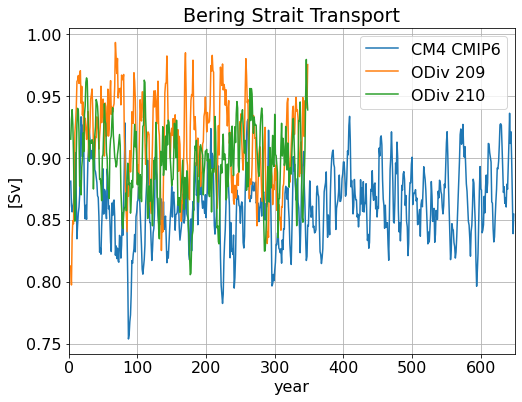

In [28]:
fig = plt.figure(figsize=(8,6))
(DS_cmip6pi.vmo.sum(dim=['z_l','xh'])*(10**-6)/rho_0).groupby('time.year').mean().chunk(
    {'year':1000}).rolling(year=5,center=True).mean().plot(label='CM4 CMIP6')
(DS_o209.vmo.sum(dim=['z_l','xh'])*(10**-6)/rho_0).groupby('time.year').mean().chunk(
    {'year':1000}).rolling(year=5,center=True).mean().plot(label='ODiv 209')
(DS_o210.vmo.sum(dim=['z_l','xh'])*(10**-6)/rho_0).groupby('time.year').mean().chunk(
    {'year':1000}).rolling(year=5,center=True).mean().plot(label='ODiv 210')
plt.legend()
plt.title('Bering Strait Transport')
plt.ylabel('[Sv]')
plt.xlim(0,650)
plt.grid()
plt.show()

## Set observational paths

In [29]:
base = '../data/BeringStraitMooring/'

## Read in observational data

In [30]:
DS_obs = xr.open_dataset(base + 'BeringStrait_Monthlymeans_Jan2021.nc')

## Check the Berring Strait cross-sectional area for each simulation

In [31]:
# CMIP6 CM4
area_cmip6 = (DS_cmip6pi.volcello.sum('z_l')/DS_cmip6pi.dyCv).sum('xh').mean('time').values
# HighRes CM4
area_hres = (DS_o209.volcello.sum('z_l')/DS_o209.dyCv).sum('xh').mean('time').values
# OM4
area_om4 = (DS_om4.volcello.sum('z_l')/DS_om4.dyCv).sum('xh').mean('time').values

In [32]:
print('Bering Strait cross-sectional area [m^3]')
print('Observations: %i' %area_BS)
print('   CMIP6 CM4: %i' %area_cmip6)
print(' HighRes CM4: %i' %area_hres)
print('     JRA OM4: %i' %area_om4)

Bering Strait cross-sectional area [m^3]
Observations: 4250000
   CMIP6 CM4: 4679148
 HighRes CM4: 4818476
     JRA OM4: 4691019


In [33]:
print('Simulated Bering Strait frational cross-sectional area')
print('  CMIP6 CM4: %.3f' %(area_cmip6/area_BS))
print('HighRes CM4: %.3f' %(area_hres/area_BS))
print('    JRA OM4: %.3f' %(area_om4/area_BS))

Simulated Bering Strait frational cross-sectional area
  CMIP6 CM4: 1.101
HighRes CM4: 1.134
    JRA OM4: 1.104


## Define transport and flux calcs

In [34]:
def calc_Bering_daily(DS):
    # Model reference density [kg/m3]
    rho_0 = 1035
    # Reference potential temperature for heat flux [deg C]
    theta_ref = -1.9
    # Heat capacity of water for model output [J/kg K]
    C_p = 3992
    # Reference salinity for freshwater flux [PSU]
    S_ref = 34.8
    
    # Volume transport
    DS['T_vol'] = DS.vmo/rho_0
    
    # Heat flux
    DS['F_heat'] = rho_0 * DS.T_vol * C_p * (DS.thetao - theta_ref) * (10**-12)
    
    # Freshwater flux
    DS['F_fresh'] = DS.T_vol * (1 - (DS.so/S_ref)) * (10**-6)
    
    return DS

## Calc volume transport [m$^3$/s], heat flux [TW], and freshwater flux [Sv]

In [35]:
# CMIP6 CM4 pi
_ = calc_Bering_daily(DS_cmip6pi)

In [36]:
# CMIP6 CM4 historical
_ = calc_Bering_daily(DS_cmip6hi)

In [37]:
# ODIV209 CM4
_ = calc_Bering_daily(DS_o209)

In [38]:
# ODIV210 CM4
_ = calc_Bering_daily(DS_o210)

In [39]:
# OM4
_ = calc_Bering_daily(DS_om4)

## Plot volume transport climatology

In [40]:
def trans_monthly(DS):
    return DS.T_vol.sum(dim=['z_l','xh']).groupby('time.month').mean()*(10**-6)

In [41]:
# Make model time series
T_cm4P = trans_monthly(DS_cmip6pi)
T_cm4H = trans_monthly(DS_cmip6hi)
T_o209 = trans_monthly(DS_o209)
T_o210 = trans_monthly(DS_o210)
T_om4 = trans_monthly(DS_om4)

In [42]:
# Make observational time series
T_obs  = DS_obs.T_vol.groupby('time.month').mean()
T_obsE = DS_obs.T_volE.groupby('time.month').mean()

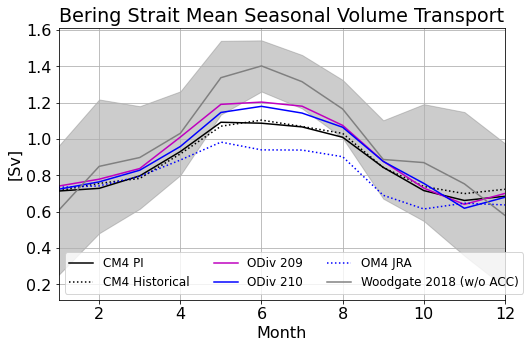

In [43]:
# Volume transport
fig = plt.figure(figsize=(8,5))
plt.plot(T_cm4P.month,T_cm4P,'k',label = 'CM4 PI')
plt.plot(T_cm4H.month,T_cm4H,'k:',label = 'CM4 Historical')
plt.plot(T_o209.month,T_o209,'m',label = 'ODiv 209')
plt.plot(T_o210.month,T_o210,'b',label = 'ODiv 210')
plt.plot(T_om4.month,T_om4,'b:',label = 'OM4 JRA')
plt.fill_between(T_obs.month,T_obs-T_obsE,T_obs+T_obsE,color='grey',alpha=0.4)
plt.plot(T_obs.month,T_obs,'grey',label = 'Woodgate 2018 (w/o ACC)')
plt.title('Bering Strait Mean Seasonal Volume Transport')
plt.ylabel('[Sv]')
plt.xlabel('Month')
plt.legend(ncol=3,prop={'size': 12})
plt.xlim(1,12)
plt.grid()
plt.show()
# save fig
fig.savefig('../figures/BeringStraitMooring/Tvol_monthly_modelObs.pdf')

## Plot heat flux climatology

In [44]:
def hflux_monthly(DS):
    return DS.F_heat.sum(dim=['z_l','xh']).groupby('time.month').mean()

In [45]:
# Make model time series
H_cm4P = hflux_monthly(DS_cmip6pi)
H_cm4H = hflux_monthly(DS_cmip6hi)
H_o209 = hflux_monthly(DS_o209)
H_o210 = hflux_monthly(DS_o210)
H_om4 = hflux_monthly(DS_om4)

In [46]:
# Make obs time series
H_obs  = DS_obs.F_heat.groupby('time.month').mean()
H_obsE = DS_obs.F_heatE.groupby('time.month').mean()

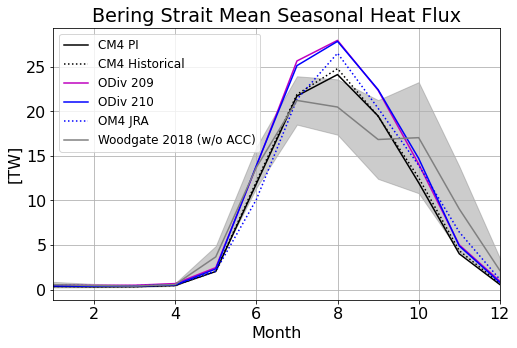

In [47]:
# Heat flux
fig = plt.figure(figsize=(8,5))
plt.plot(H_cm4P.month,H_cm4P,'k',label = 'CM4 PI')
plt.plot(H_cm4H.month,H_cm4H,'k:',label = 'CM4 Historical')
plt.plot(H_o209.month,H_o209,'m',label = 'ODiv 209')
plt.plot(H_o210.month,H_o210,'b',label = 'ODiv 210')
plt.plot(H_om4.month,H_om4,'b:',label = 'OM4 JRA')
plt.fill_between(H_obs.month,H_obs-H_obsE,H_obs+H_obsE,color='grey',alpha=0.4)
plt.plot(H_obs.month,H_obs,'grey',label = 'Woodgate 2018 (w/o ACC)')
plt.title('Bering Strait Mean Seasonal Heat Flux')
plt.ylabel('[TW]')
plt.xlabel('Month')
plt.legend(ncol=1,loc='upper left',prop={'size': 12})
plt.xlim(1,12)
plt.grid()
plt.show()
# save fig
fig.savefig('../figures/BeringStraitMooring/Fheat_monthly_modelObs.pdf')

## Plot freshwater flux climatology

In [48]:
def fflux_monthly(DS):
    return DS.F_fresh.sum(dim=['z_l','xh']).groupby('time.month').mean()

In [49]:
# Make model time series
F_cm4P = fflux_monthly(DS_cmip6pi)
F_cm4H = fflux_monthly(DS_cmip6hi)
F_o209 = fflux_monthly(DS_o209)
F_o210 = fflux_monthly(DS_o210)
F_om4 = fflux_monthly(DS_om4)

In [50]:
# Make obs time series
F_obs  = DS_obs.F_fresh.groupby('time.month').mean()
F_obsE = DS_obs.F_fresh.groupby('time.month').mean()

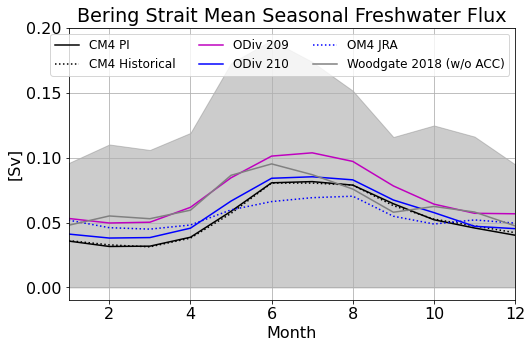

In [51]:
# Volume transport
fig = plt.figure(figsize=(8,5))
plt.plot(F_cm4P.month,F_cm4P,'k',label = 'CM4 PI')
plt.plot(F_cm4H.month,F_cm4H,'k:',label = 'CM4 Historical')
plt.plot(F_o209.month,F_o209,'m',label = 'ODiv 209')
plt.plot(F_o210.month,F_o210,'b',label = 'ODiv 210')
plt.plot(F_om4.month,F_om4,'b:',label = 'OM4 JRA')
plt.fill_between(F_obs.month,F_obs-F_obsE,F_obs+F_obsE,color='grey',alpha=0.4)
plt.plot(F_obs.month,F_obs,'grey',label = 'Woodgate 2018 (w/o ACC)')
plt.title('Bering Strait Mean Seasonal Freshwater Flux')
plt.ylabel('[Sv]')
plt.xlabel('Month')
plt.legend(ncol=3,prop={'size': 12})
plt.xlim(1,12)
plt.grid()
plt.show()
# save fig
fig.savefig('../figures/BeringStraitMooring/Ffresh_monthly_modelObs.pdf')

## Plot v velocity climatology for mooring location

In [52]:
def v_monthly(DS):
    # Lat, Lon, depth of mooring observations
    llz = [66 + (19.6/60), -168 - (57.5/60), 57]
    
    return DS.vo.isel(xh=abs(DS.geolon_v - llz[1]).argmin()
                     ).sel(z_l=llz[-1],method='nearest').groupby('time.month').mean()

In [53]:
# Make model time series
v_cm4P = v_monthly(DS_cmip6pi)
v_cm4H = v_monthly(DS_cmip6hi)
v_o209 = v_monthly(DS_o209)
v_o210 = v_monthly(DS_o210)
v_om4 = v_monthly(DS_om4)

In [54]:
# Make obs time series
v_obs  = DS_obs.vo.groupby('time.month').mean()
v_obsE = DS_obs.voE.groupby('time.month').mean()

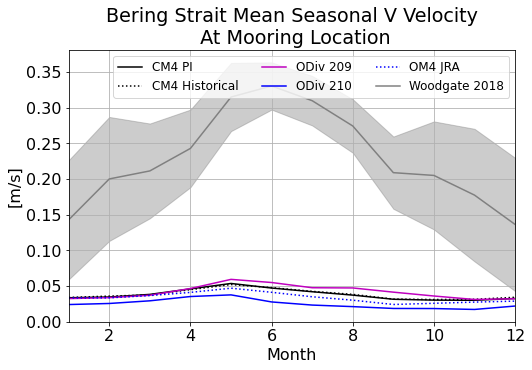

In [55]:
# V velocity
fig = plt.figure(figsize=(8,5))
plt.plot(v_cm4P.month,v_cm4P,'k',label = 'CM4 PI')
plt.plot(v_cm4H.month,v_cm4H,'k:',label = 'CM4 Historical')
plt.plot(v_o209.month,v_o209,'m',label = 'ODiv 209')
plt.plot(v_o210.month,v_o210,'b',label = 'ODiv 210')
plt.plot(v_om4.month,v_om4,'b:',label = 'OM4 JRA')
plt.fill_between(v_obs.month,v_obs-v_obsE,v_obs+v_obsE,color='grey',alpha=0.4)
plt.plot(v_obs.month,v_obs,'grey',label = 'Woodgate 2018')
plt.title('Bering Strait Mean Seasonal V Velocity\n At Mooring Location')
plt.ylabel('[m/s]')
plt.xlabel('Month')
plt.legend(ncol=3,prop={'size': 12})
plt.xlim(1,12)
plt.grid()
plt.show()
# save fig
fig.savefig('../figures/BeringStraitMooring/vo_monthly_modelObs.pdf')

## Plot v velocity climatology for mooring depth

In [56]:
def v_atz_monthly(DS):
    # Lat, Lon, depth of mooring observations
    llz = [66 + (19.6/60), -168 - (57.5/60), 57]
    
    return DS.vo.sel(z_l=llz[-1],method='nearest'
                    ).mean('xh').groupby('time.month').mean()

In [57]:
# Make model time series
v_cm4P = v_atz_monthly(DS_cmip6pi)
v_cm4H = v_atz_monthly(DS_cmip6hi)
v_o209 = v_atz_monthly(DS_o209)
v_o210 = v_atz_monthly(DS_o210)
v_om4 = v_atz_monthly(DS_om4)

In [58]:
# Make obs time series
v_obs  = DS_obs.vo.groupby('time.month').mean()
v_obsE = DS_obs.voE.groupby('time.month').mean()

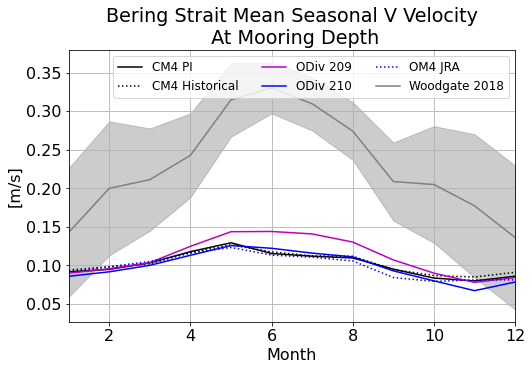

In [59]:
# V velocity
fig = plt.figure(figsize=(8,5))
plt.plot(v_cm4P.month,v_cm4P,'k',label = 'CM4 PI')
plt.plot(v_cm4H.month,v_cm4H,'k:',label = 'CM4 Historical')
plt.plot(v_o209.month,v_o209,'m',label = 'ODiv 209')
plt.plot(v_o210.month,v_o210,'b',label = 'ODiv 210')
plt.plot(v_om4.month,v_om4,'b:',label = 'OM4 JRA')
plt.fill_between(v_obs.month,v_obs-v_obsE,v_obs+v_obsE,color='grey',alpha=0.4)
plt.plot(v_obs.month,v_obs,'grey',label = 'Woodgate 2018')
plt.title('Bering Strait Mean Seasonal V Velocity\n At Mooring Depth')
plt.ylabel('[m/s]')
plt.xlabel('Month')
plt.legend(ncol=3,prop={'size': 12})
plt.xlim(1,12)
plt.grid()
plt.show()
# save fig
fig.savefig('../figures/BeringStraitMooring/vo_mz_monthly_modelObs.pdf')

## Plot temperature climatology for mooring location

In [60]:
def T_monthly(DS):
    # Lat, Lon, depth of mooring observations
    llz = [66 + (19.6/60), -168 - (57.5/60), 57]
    
    return DS.thetao.isel(xh=abs(DS.geolon_v - llz[1]).argmin()
                         ).sel(z_l=llz[-1],method='nearest').groupby('time.month').mean()

In [61]:
# Make time series
T_cm4P = T_monthly(DS_cmip6pi)
T_cm4H = T_monthly(DS_cmip6hi)
T_o209 = T_monthly(DS_o209)
T_o210 = T_monthly(DS_o210)
T_om4 = T_monthly(DS_om4)

In [62]:
# Make time series
T_obs  = DS_obs.thetao.groupby('time.month').mean()
T_obsE = DS_obs.thetaoE.groupby('time.month').mean()

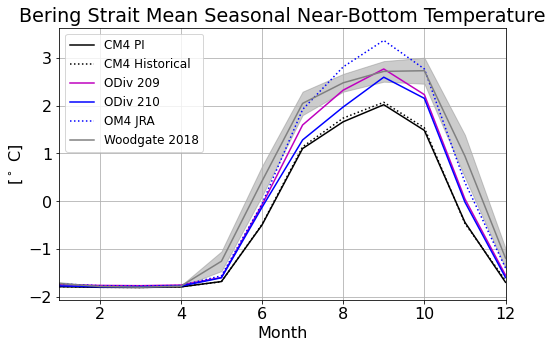

In [63]:
# V velocity
fig = plt.figure(figsize=(8,5))
plt.plot(T_cm4P.month,T_cm4P,'k',label = 'CM4 PI')
plt.plot(T_cm4H.month,T_cm4H,'k:',label = 'CM4 Historical')
plt.plot(T_o209.month,T_o209,'m',label = 'ODiv 209')
plt.plot(T_o210.month,T_o210,'b',label = 'ODiv 210')
plt.plot(T_om4.month,T_om4,'b:',label = 'OM4 JRA')
plt.fill_between(T_obs.month,T_obs-T_obsE,T_obs+T_obsE,color='grey',alpha=0.4)
plt.plot(T_obs.month,T_obs,'grey',label = 'Woodgate 2018')
plt.title('Bering Strait Mean Seasonal Near-Bottom Temperature')
plt.ylabel('[$^\circ$ C]')
plt.xlabel('Month')
plt.legend(ncol=1,prop={'size': 12},loc='upper left')
plt.xlim(1,12)
plt.grid()
plt.show()
# save fig
fig.savefig('../figures/BeringStraitMooring/thetao_monthly_modelObs.pdf')

## Plot salinity climatology for mooring location

In [64]:
def S_monthly(DS):
    # Lat, Lon, depth of mooring observations
    llz = [66 + (19.6/60), -168 - (57.5/60), 57]
    
    return DS.so.isel(xh=abs(DS.geolon_v - llz[1]).argmin()
                     ).sel(z_l=llz[-1],method='nearest').groupby('time.month').mean()

In [65]:
# Make model time series
S_cm4P = S_monthly(DS_cmip6pi)
S_cm4H = S_monthly(DS_cmip6hi)
S_o209 = S_monthly(DS_o209)
S_o210 = S_monthly(DS_o210)
S_om4 = S_monthly(DS_om4)

In [66]:
# Make obs time series
S_obs  = DS_obs.so.groupby('time.month').mean()
S_obsE = DS_obs.soE.groupby('time.month').mean()

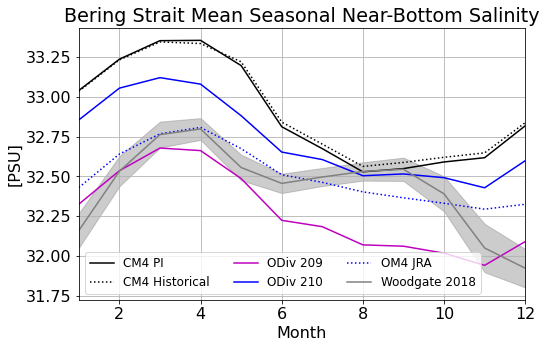

In [67]:
# Salinity
fig = plt.figure(figsize=(8,5))
plt.plot(S_cm4P.month,S_cm4P,'k',label = 'CM4 PI')
plt.plot(S_cm4H.month,S_cm4H,'k:',label = 'CM4 Historical')
plt.plot(S_o209.month,S_o209,'m',label = 'ODiv 209')
plt.plot(S_o210.month,S_o210,'b',label = 'ODiv 210')
plt.plot(S_om4.month,S_om4,'b:',label = 'OM4 JRA')
plt.fill_between(S_obs.month,S_obs-S_obsE,S_obs+S_obsE,color='grey',alpha=0.4)
plt.plot(S_obs.month,S_obs,'grey',label = 'Woodgate 2018')
plt.title('Bering Strait Mean Seasonal Near-Bottom Salinity')
plt.ylabel('[PSU]')
plt.xlabel('Month')
plt.legend(ncol=3,prop={'size': 12})
plt.xlim(1,12)
plt.grid()
plt.show()
# save fig
fig.savefig('../figures/BeringStraitMooring/so_monthly_modelObs.pdf')